# Object Localization

**Object localization** is a computer vision task that involves identifying the location of objects within an image. The goal is to determine the precise coordinates of the object, usually by drawing a bounding box around it. Object localization is a crucial step in more complex tasks like object detection, where the model not only identifies the presence of an object but also determines its exact position in the image.

In this notebook, we are going to train the EfficientNet_b0 model to perform this task.

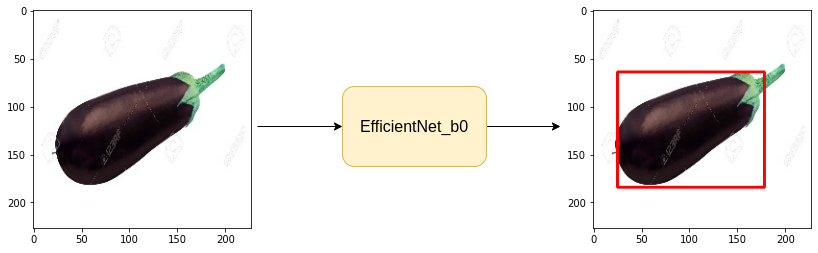

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pk2dfjs1
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pk2dfjs1
  Resolved https://github.com/albumentations-team/albumentations to commit b1ebad4c932235918d0aeccf51d070c3080e7516
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.8 MB/s eta 0:00:00


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 34.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

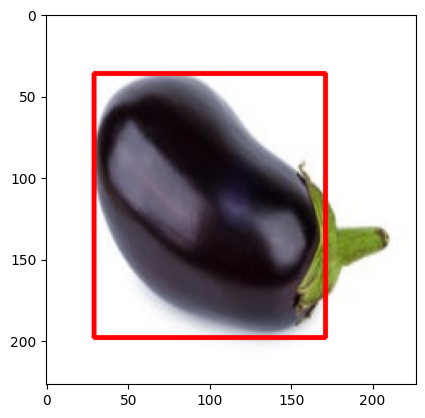

In [30]:
row = df.iloc[12]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
plt.imshow(img)

In [31]:
train_df, valid_df = train_test_split(df,test_size=0.20,random_state=42)

# Augmentations

In [16]:
import albumentations as A

In [24]:
train_augs = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate()
],bbox_params=A.BboxParams(format = "pascal_voc",label_fields = ['class_labels']))

valid_augs = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE)
],bbox_params=A.BboxParams(format = "pascal_voc",label_fields = ['class_labels']))


# Create Custom Dataset

In [25]:
class ObjectLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin,ymin,xmax,ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(DATA_DIR + row.img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if self.augmentations :
      data = self.augmentations(image=img,bboxes=bbox,class_labels=[None])
      img = data["image"]
      bbox = data["bboxes"][0]

    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    bbox = torch.Tensor(bbox)
    return img, bbox


In [26]:
trainset = ObjectLocDataset(train_df,train_augs)
validset = ObjectLocDataset(valid_df,valid_augs)

In [27]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


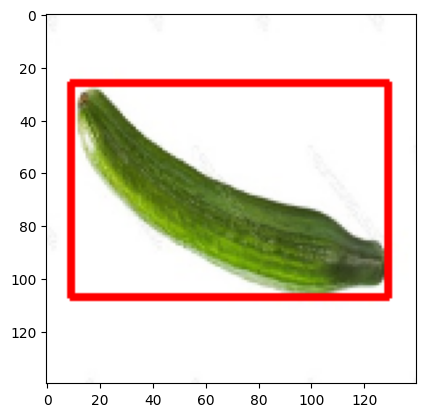

In [28]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [32]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [33]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [34]:
for images, bboxes in trainloader:
    break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [35]:
from torch import nn
import timm

In [36]:
class ObjLocalModel(nn.Module):
    def __init__(self):
      super(ObjLocalModel, self).__init__()

      self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)

    def forward(self,images,gt_bboxes=None):
      bboxes = self.backbone(images)
      if gt_bboxes != None :
        loss = nn.MSELoss()(bboxes,gt_bboxes)
        return bboxes,loss
      return bboxes

In [38]:
model = ObjLocalModel()
model.to(DEVICE);

In [39]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [40]:
def train_fn(model,dataloader,optimizer):
    total_loss = 0.0
    model.train() # DropOut Layer should be ON

    for data in tqdm(dataloader): # Loop over batches
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        bboxes, loss = model(images,gt_bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [41]:
def eval_fn(model,dataloader):
    total_loss = 0.0
    model.eval() # DropOut Layer should be OFF

    with torch.no_grad():
        for data in tqdm(dataloader): # Loop over batches
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            bboxes, loss = model(images,gt_bboxes)

            total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [42]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [43]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model,trainloader,optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss :
        torch.save(model.state_dict(), 'best_model.pt')
        print("Weights are saved !")
        best_valid_loss = valid_loss

    print(f"Epoch : {i + 1} train loss : {train_loss} valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 1 train loss : 5299.176904296875 valid loss : 2320.4114990234375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 2 train loss : 2056.8275756835938 valid loss : 2155.8292643229165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 3 train loss : 1101.3548828125 valid loss : 417.36997477213544


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 4 train loss : 715.5303100585937 valid loss : 239.93641153971353


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 5 train loss : 489.9895935058594 valid loss : 166.63106791178384


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 6 train loss : 339.2768615722656 valid loss : 127.75032297770183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss : 288.4919860839844 valid loss : 180.4990234375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss : 188.11512603759766 valid loss : 136.93421173095703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 9 train loss : 151.93897018432617 valid loss : 122.4695536295573


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss : 134.3874656677246 valid loss : 138.03616841634116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 11 train loss : 115.68960876464844 valid loss : 109.13678232828777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 12 train loss : 108.23226776123047 valid loss : 100.02316792805989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss : 99.75139236450195 valid loss : 126.78182474772136


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss : 95.93232574462891 valid loss : 121.18600209554036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 15 train loss : 85.09505691528321 valid loss : 99.69981892903645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 88.28810272216796 valid loss : 99.87212880452473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 87.52735214233398 valid loss : 102.22525278727214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 18 train loss : 75.26358337402344 valid loss : 69.49451573689778


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 train loss : 48.13028144836426 valid loss : 94.56915537516277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss : 56.55357475280762 valid loss : 74.36031595865886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss : 56.7701919555664 valid loss : 87.22918192545573


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved !
Epoch : 22 train loss : 50.69969635009765 valid loss : 59.377908070882164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 60.141394805908206 valid loss : 83.08956909179688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss : 53.1257137298584 valid loss : 73.84012858072917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 62.68381538391113 valid loss : 101.9403190612793


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss : 58.639831924438475 valid loss : 84.37853876749675


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss : 60.673103141784665 valid loss : 102.89418029785156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss : 55.432513046264646 valid loss : 111.77032979329427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss : 60.66454391479492 valid loss : 62.507485707600914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 44.060305786132815 valid loss : 72.25008138020833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 46.603703308105466 valid loss : 80.96767679850261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 48.49322395324707 valid loss : 68.5412089029948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss : 46.63539199829101 valid loss : 74.92229715983073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 37.95598239898682 valid loss : 88.47676849365234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 40.33428115844727 valid loss : 83.26187388102214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 37.74837799072266 valid loss : 96.3815205891927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 53.079651260375975 valid loss : 85.0458869934082


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 41.368261909484865 valid loss : 73.18471018473308


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss : 51.58680305480957 valid loss : 84.6381009419759


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss : 44.05658931732178 valid loss : 69.09041213989258


#Inference

In [44]:
import utils

<ipython-input-50-fd500f89105b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model.pt"))


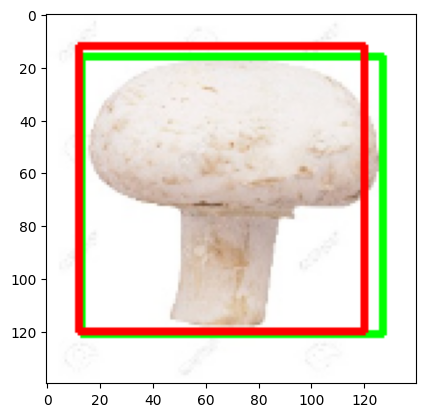

In [50]:
model.load_state_dict(torch.load("/content/best_model.pt"))

model.eval()
with torch.no_grad():
    image, gt_bbox = validset[1] #(c, h, w)
    image = image.unsqueeze(0).to(DEVICE) #(bs, c, h, w)
    out_bbox = model(image)

    utils.compare_plots(image,gt_bbox,out_bbox)
